<a href="https://colab.research.google.com/github/Sandeep2017/Diabetic-Retinopathy-detection/blob/master/DR2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import files
files.upload()

!ls -lha kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5961805/


Saving kaggle.json to kaggle.json
-rw-r--r-- 1 root root 67 Apr  9 10:57 kaggle.json


In [0]:
!nvidia-smi

Thu Apr  9 10:58:02 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!kaggle datasets download -d dola1507108/diabetic-retinopathy-classified

100% 7.25G/7.26G [02:40<00:00, 44.3MB/s]
100% 7.26G/7.26G [02:40<00:00, 48.7MB/s]


In [0]:
!unzip \*.zip

In [0]:

!rm -rf /content/diabetic-retinopathy-customized/resized_train

In [0]:
!ls

diabetic-retinopathy-customized  kaggle.json  sample_data


In [0]:
import numpy as np
import os
%tensorflow_version 1.x
from keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.layers import Dense, Activation, Flatten
from keras.layers import merge, Input
from keras.models import Model
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import sklearn

TensorFlow 1.x selected.


Using TensorFlow backend.


In [0]:
# Parameters
BATCH_SIZE = 32 
CLASSES = 5 # No. of output classes
EPOCH = 10 

In [0]:
BASE_DIR = '/content/diabetic-retinopathy-customized/resized_train_cropped/resized_train_cropped'

In [0]:
os.listdir(BASE_DIR)

['level_2', 'level_0', 'level_4', 'level_3', 'level_1']

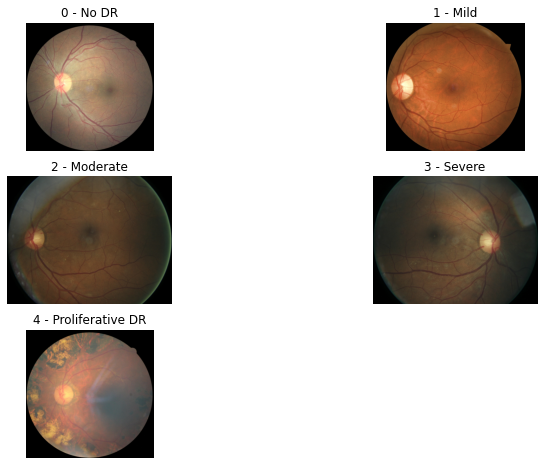

In [0]:
import cv2
import matplotlib.pyplot as plt

def Plot(image_path):
    image = cv2.imread(image_path)  # BGR
    image = image[:, :, [2, 1, 0]]  # RGB
    plt.imshow(image)
    return

plt.figure(figsize=(12,8))
plt.subplot(321)
plt.title('0 - No DR'); 
plt.axis('off'); 
Plot(os.path.join(BASE_DIR, 'level_0/10003_left.jpeg'))

plt.subplot(322)
plt.title('1 - Mild'); 
plt.axis('off'); 
Plot(os.path.join(BASE_DIR, 'level_1/10030_left.jpeg'))

plt.subplot(323)
plt.title('2 - Moderate'); 
plt.axis('off'); 
Plot(os.path.join(BASE_DIR, 'level_2/1002_right.jpeg'))

plt.subplot(324)
plt.title('3 - Severe'); 
plt.axis('off'); 
Plot(os.path.join(BASE_DIR, 'level_3/1002_left.jpeg'))


plt.subplot(325)
plt.title('4 - Proliferative DR'); 
plt.axis('off'); 
Plot(os.path.join(BASE_DIR, 'level_4/10017_left.jpeg'))

In [0]:
print('Training samples:\n')
TRAIN_DIR = BASE_DIR
num_samples = 0

for n in os.listdir(TRAIN_DIR): 
    
    
    num = len(os.listdir(os.path.join(TRAIN_DIR, n)))
    num_samples = num_samples + num
    print('STAGE: {:15s} Number of samples: {}'.format(n, num))
    print("..............................................")
    
print('Total training samples: {:d}\n'.format(num_samples))

Training samples:

STAGE: level_2         Number of samples: 5288
..............................................
STAGE: level_0         Number of samples: 25802
..............................................
STAGE: level_4         Number of samples: 708
..............................................
STAGE: level_3         Number of samples: 872
..............................................
STAGE: level_1         Number of samples: 2438
..............................................
Total training samples: 35108



In [0]:
IMG_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 50
NUM_CLASSES = 5
CATEGORIES = ['0','1','2','3','4']

In [0]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,width_shift_range=0.1,
                                        height_shift_range=0.1,
                                        rotation_range=15,
                                        zoom_range=0.1)
                

#test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=(IMG_SIZE, IMG_SIZE),
        color_mode='rgb',
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=None,
        class_mode="categorical")

'''
test_generator = test_datagen.flow_from_directory(
        TEST_DIR,
        target_size=(IMG_SIZE, IMG_SIZE),
        color_mode='rgb',
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=None,
        class_mode="categorical")'''

Found 35108 images belonging to 5 classes.


'\ntest_generator = test_datagen.flow_from_directory(\n        TEST_DIR,\n        target_size=(IMG_SIZE, IMG_SIZE),\n        color_mode=\'rgb\',\n        batch_size=BATCH_SIZE,\n        shuffle=True,\n        seed=None,\n        class_mode="categorical")'

In [0]:

%tensorflow_version 1.x
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import Flatten
from keras.layers import Dense


TensorFlow is already loaded. Please restart the runtime to change versions.


In [0]:
model = Sequential()
    
model.add(Conv2D(16, (3, 3), activation='relu', padding="same", input_shape=(IMG_SIZE,IMG_SIZE,3)))
model.add(Conv2D(16, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(Conv2D(96, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(Conv2D(96, (3, 3), padding="valid", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(Conv2D(128, (3, 3), padding="valid", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(Flatten())
    
model.add(Dropout(0.1))
model.add(BatchNormalization())
    
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
    
model.add(Dense(NUM_CLASSES , activation='softmax'))

In [0]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 256, 256, 16)      448       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 256, 256, 16)      2320      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 128, 128, 16)      0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 128, 128, 16)      0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 128, 128, 16)      64        
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 128, 128, 32)      4640      
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 128, 128, 32)     

In [0]:
from keras import optimizers
from keras.optimizers import Adam, SGD , RMSprop
from keras.losses import sparse_categorical_crossentropy, binary_crossentropy

model.compile(optimizer=Adam(lr=0.01),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])



In [0]:
STEP_SIZE_TRAIN=train_generator.n // train_generator.batch_size 
#STEP_SIZE_VALID=test_generator.n // test_generator.batch_size

In [0]:
STEP_SIZE_TRAIN=train_generator.n // train_generator.batch_size 
#STEP_SIZE_VALID=test_generator.n // test_generator.batch_size
history = model.fit_generator(
      train_generator,
      steps_per_epoch=STEP_SIZE_TRAIN, 
      epochs=EPOCHS)  
    



Epoch 1/50
1097/1097 [==============================] - 955s 871ms/step - loss: 0.9219 - acc: 0.7289
Epoch 2/50
1097/1097 [==============================] - 957s 872ms/step - loss: 0.8739 - acc: 0.7346
Epoch 3/50
1097/1097 [==============================] - 964s 879ms/step - loss: 0.8706 - acc: 0.7351
Epoch 4/50
1097/1097 [==============================] - 942s 859ms/step - loss: 0.8719 - acc: 0.7348
Epoch 5/50
 821/1097 [=====================>........] - ETA: 3:56 - loss: 0.8670 - acc: 0.7360

In [0]:
model = Sequential()
    
model.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(512,512,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

    
model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

    
model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu', padding="same"))
#model.add(BatchNormalization())
#model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512, (3, 3), activation='relu', padding="same"))
#model.add(BatchNormalization())
#model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512, (3, 3), activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())

    
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1024, activation='relu'))

model.add(Dense(NUM_CLASSES , activation='softmax'))



model.summary()

In [0]:
from keras import optimizers
from keras.optimizers import Adam, SGD , RMSprop
from keras.losses import sparse_categorical_crossentropy, binary_crossentropy

model.compile(optimizer=Adam(lr=0.0001),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])


In [0]:

#Callbacks
checkpoint = ModelCheckpoint(filepath = 'drive/My Drive/X-Ray/best_weights.hdf5', 
                             save_best_only = True, 
                             save_weights_only = True)

In [0]:
# Learning rate reduction
lr_reduce = ReduceLROnPlateau(monitor = 'val_loss', 
                              factor = 0.3, 
                              patience = 2, 
                              verbose = 2, 
                              mode = 'max')
# Early Stop
early_stop = EarlyStopping(monitor = 'val_loss', 
                           min_delta = 0.1, 
                           patience = 1, 
                           mode = 'min')

In [0]:
STEP_SIZE_TRAIN=train_generator.n // train_generator.batch_size 
#STEP_SIZE_VALID=test_generator.n // test_generator.batch_size
history = model.fit_generator(
      train_generator,
      steps_per_epoch=STEP_SIZE_TRAIN, 
      epochs=50)
    

